#Homework 5: Lab (13 points)
##Name: Shaobo Liang (sliang24), Zehua Wang (zwang258), Kit Ao (mao2)

Please refer to the PDF description for homework 5 for a detailed description of the goals of this assignment.

You will hand in a PDF of this notebook. Please be sure to clearly answer each question listed at the end of the notebook.

##Setup the code.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

##Load the Data

In [2]:
df = pd.read_csv("BPD_2012_2017.csv")
print(len(df))
# Drop missing values
df = df.dropna(subset=['Longitude', 'Latitude'])
# Show first 3 rows
df.head(3)

276529


,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents
0,09/02/2017,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1
1,09/02/2017,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,O,NaN,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1
2,09/02/2017,22:53:00,9S,600 RADNOR AV,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1


(274325, 2)


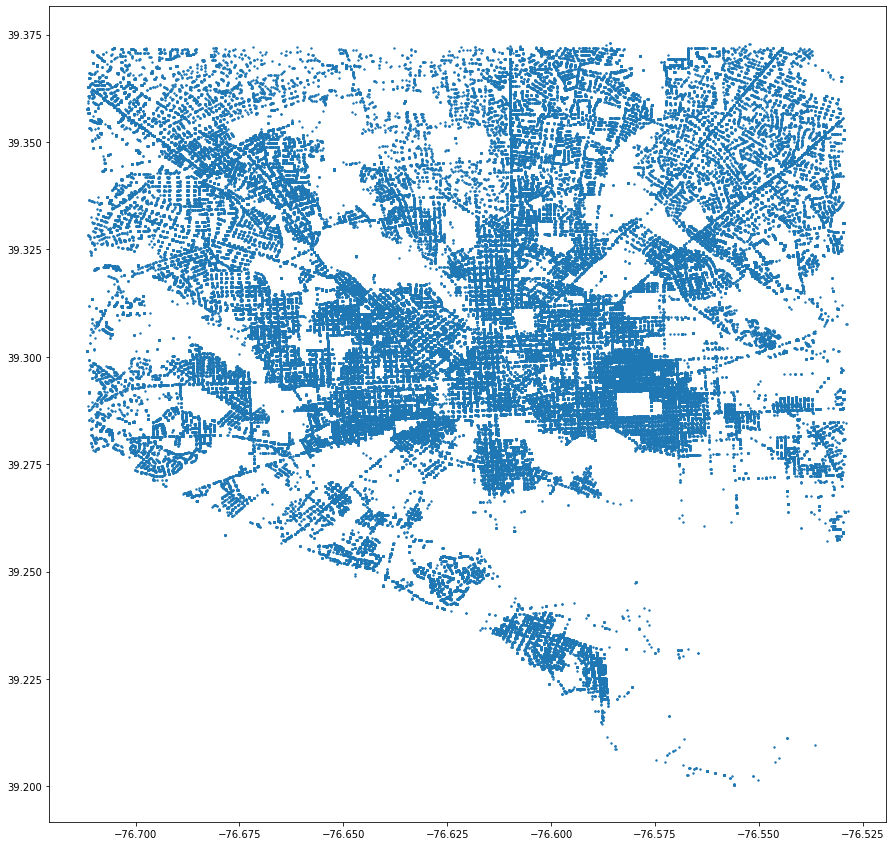

In [3]:
X = df[['Longitude', 'Latitude']].to_numpy()
print(X.shape)
# We don't need a test set for this task, so we use the whole dataset as the training set
plt.figure(figsize=(15,15))
plt.scatter(X[:,0], X[:,1], 2)

##Define the K-Means Model (TODO)

In [35]:
class Kmeans:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.prototypes = np.array([])
        self.distances = np.array([])
        self.which_clusters = np.array([])
        
    def pairwise_distance(self, X, C):
        # Calculate the pairwise Euclidean distance between two numpy arrays X and C
        # X: N x D, i.e. N points in X
        # C: K x D, i.e. K points in C
        # return: N x K
        dists = np.empty([X.shape[0], C.shape[0]])
        for i in range(X.shape[0]):
            for k in range(C.shape[0]):
                dists[i][k] = np.linalg.norm(X[i]-C[k]) 
        return dists
    
    def fit(self, X_train, max_iter=100):
        n_samples = X_train.shape[0]
        
        #########################Step 1##########################
        # 1.1 Assign a random point as the prototype for each cluster
        idx = np.random.random_integers(0, X.shape[0] - 1)
        self.prototypes = np.reshape(X[idx], (1,2))
        for i in range(self.n_clusters - 1):
            idx = np.random.random_integers(0, X.shape[0] - 1)
            self.prototypes = np.vstack((self.prototypes, X[idx]))
        # self.prototypes is a (n_clusters, 2) array
        
        # 1.2 Calculate the distance between samples and initial prototypes
        # You may use the self.pairwise_distance function
        self.distances = self.pairwise_distance(X_train, self.prototypes) # prototypes shape: (n_clusters, 2); X_train shape: (274325, 2)
        #self.distances.shape = (274325, n_clusters)
        
        
        # 1.3 Assign points to clusters
        tmp_list = []
        for cluster_distances in self.distances:
            tmp_list.append(np.argmin(cluster_distances))
        self.which_clusters = np.array(tmp_list)
        
        # self.which_clusters.shape = 27435
        
        inertia = 0.0
        
        # Start iterative training
        for n_iter in range(max_iter):
            inertia = 0.0
            prev_which_clusters = self.which_clusters
            
            ######################Step 2#########################
            # Update the prototypes
            sum_distances = np.zeros((self.n_clusters, 2))
            num_points_per_cluster = np.zeros(self.n_clusters)
            for i in range(self.which_clusters.shape[0]):
                sum_distances[self.which_clusters[i]][0] += X_train[i][0]
                sum_distances[self.which_clusters[i]][1] += X_train[i][1]
                num_points_per_cluster[self.which_clusters[i]] += 1
            for i in range(self.n_clusters):
                self.prototypes[i][0] = sum_distances[i][0] / num_points_per_cluster[i]
                self.prototypes[i][1] = sum_distances[i][1] / num_points_per_cluster[i]
            
            ######################Step 3#########################
            # 3.1 Calculate the updated distance between samples and prototypes
            # You may use the self.pairwise_distance function
            self.distances = self.pairwise_distance(X_train, self.prototypes)
            # 3.2 Assign points to clusters
            tmp_list = []
            for cluster_distances in self.distances:
                tmp_list.append(np.argmin(cluster_distances))
            self.which_clusters = np.array(tmp_list)
        
            ######################Step 4#########################
            # Calculate the inertia
            for i in range(self.which_clusters.shape[0]):
                inertia += self.distances[i][self.which_clusters[i]] ** 2
            
            if (n_iter+1) % 10 == 0:
                print("#Iteration: ", n_iter, "; inertia: {:.2f}".format(inertia))
                             
            ######################Step 5#########################
            # Check convergence: whether new cluster assignments are the same as previous cluster assignments
            if np.array_equal(prev_which_clusters, self.which_clusters):
                print("Converged at iteration {0} with inertia {1:.2f}!".format(str(n_iter), inertia))
                break
        return inertia

    def predict(self, X):
        # Predict the cluster assignments for examples
        # return: an numpy array with the length of X.shape[0]
#         cluster_ids = np.zeros(X.shape[0])
        
        X_distances = self.pairwise_distance(X, self.prototypes) 
        tmp_list = []
        for cluster_distances in X_distances:
            tmp_list.append(np.argmin(cluster_distances))
            
        return np.array(tmp_list)
        
#         return cluster_ids

##Find the Elbow

In [38]:
def plot_tune_n_clusters(X_train, max_clusters, max_iter=40):
    inertias = []
    for k in range(max_clusters):
        kmeans = Kmeans(k+1)
        print()
        print("#Cluster: ", (k+1))
        inertias.append(kmeans.fit(X_train, max_iter))
    plt.plot(np.arange(max_clusters) + 1, inertias)
    plt.show()
    return inertias

Q1. (11 points) Show the plot of inertia with number of clusters from 1 to 15. Report which number of clusters is at the elbow.

Please train your K-Means models on a subset of X (X_small) for this question, otherwise it takes too long to finish training. In practice, you may use the whole dataset to select n_cluster, if the computational resources allow.


#Cluster:  1


C:\Users\liang\AppData\Local\Temp\ipykernel_38420\4071194143.py:24: DeprecationWarning: This function is deprecated. Please call randint(0, 274324 + 1) instead
  idx = np.random.random_integers(0, X.shape[0] - 1)


Converged at iteration 0 with inertia 72.78!

#Cluster:  2


C:\Users\liang\AppData\Local\Temp\ipykernel_38420\4071194143.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 274324 + 1) instead
  idx = np.random.random_integers(0, X.shape[0] - 1)


#Iteration:  9 ; inertia: 39.50
Converged at iteration 18 with inertia 39.50!

#Cluster:  3
#Iteration:  9 ; inertia: 27.29
Converged at iteration 15 with inertia 27.28!

#Cluster:  4
#Iteration:  9 ; inertia: 21.92
#Iteration:  19 ; inertia: 21.29
Converged at iteration 28 with inertia 21.28!

#Cluster:  5
#Iteration:  9 ; inertia: 17.84
#Iteration:  19 ; inertia: 17.83
#Iteration:  29 ; inertia: 17.83
#Iteration:  39 ; inertia: 17.83

#Cluster:  6
#Iteration:  9 ; inertia: 14.56
#Iteration:  19 ; inertia: 14.24
#Iteration:  29 ; inertia: 14.22
Converged at iteration 34 with inertia 14.22!

#Cluster:  7
#Iteration:  9 ; inertia: 11.29
Converged at iteration 14 with inertia 11.29!

#Cluster:  8
#Iteration:  9 ; inertia: 10.10
#Iteration:  19 ; inertia: 9.72
Converged at iteration 26 with inertia 9.72!

#Cluster:  9
#Iteration:  9 ; inertia: 9.04
#Iteration:  19 ; inertia: 8.72
#Iteration:  29 ; inertia: 8.62
Converged at iteration 33 with inertia 8.62!

#Cluster:  10
#Iteration:  9 ; i

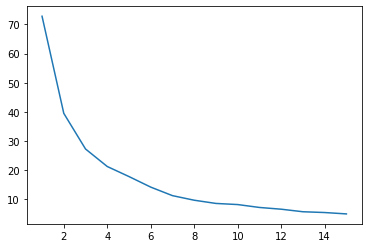

[72.77724796874233,
 39.49889472581698,
 27.282306373307986,
 21.277278098734385,
 17.830969120275576,
 14.215809669515993,
 11.291864816546735,
 9.724327519910721,
 8.622212685134276,
 8.23782121140819,
 7.245434996240552,
 6.647695992386549,
 5.775320697652736,
 5.506206548239484,
 5.031913523089013]

In [39]:
X_small = X[np.random.choice(X.shape[0], size=int(X.shape[0]*0.1), replace=False),:]  # Do not change this line of code, you should train kmeans on X_small for this question.
#TODO
#You might use the plot_tune_n_clusters function
plot_tune_n_clusters(X_small, max_clusters=15)

<font size="5">We think that the elbow is at n_clusters = 7, because the decrease of inertia starts to slow down after this point (from around 3 to 1.5 and less). </font>


##Visualization


In [40]:
def plot_clusters(kmeans, X_train, cluster_ids):
    plt.figure(figsize=(15,15))
    for i in range(np.max(cluster_ids)+1):
        plt.scatter(X_train[cluster_ids == i, 0] , X_train[cluster_ids == i, 1] , s=2, label = i)
        plt.scatter(kmeans.prototypes[i,0], kmeans.prototypes[i, 1], label=i, s=500, marker="*")
    plt.show()

Q2. (2 points) Train your model with the selected number of clusters in Q1 and  plot the cluster assignments using the *plot_clusters* function.

Train on the whole dataset for this question.

C:\Users\liang\AppData\Local\Temp\ipykernel_38420\4071194143.py:24: DeprecationWarning: This function is deprecated. Please call randint(0, 274324 + 1) instead
  idx = np.random.random_integers(0, X.shape[0] - 1)
C:\Users\liang\AppData\Local\Temp\ipykernel_38420\4071194143.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 274324 + 1) instead
  idx = np.random.random_integers(0, X.shape[0] - 1)


#Iteration:  9 ; inertia: 117.87
#Iteration:  19 ; inertia: 113.24
#Iteration:  29 ; inertia: 113.24
Converged at iteration 30 with inertia 113.24!


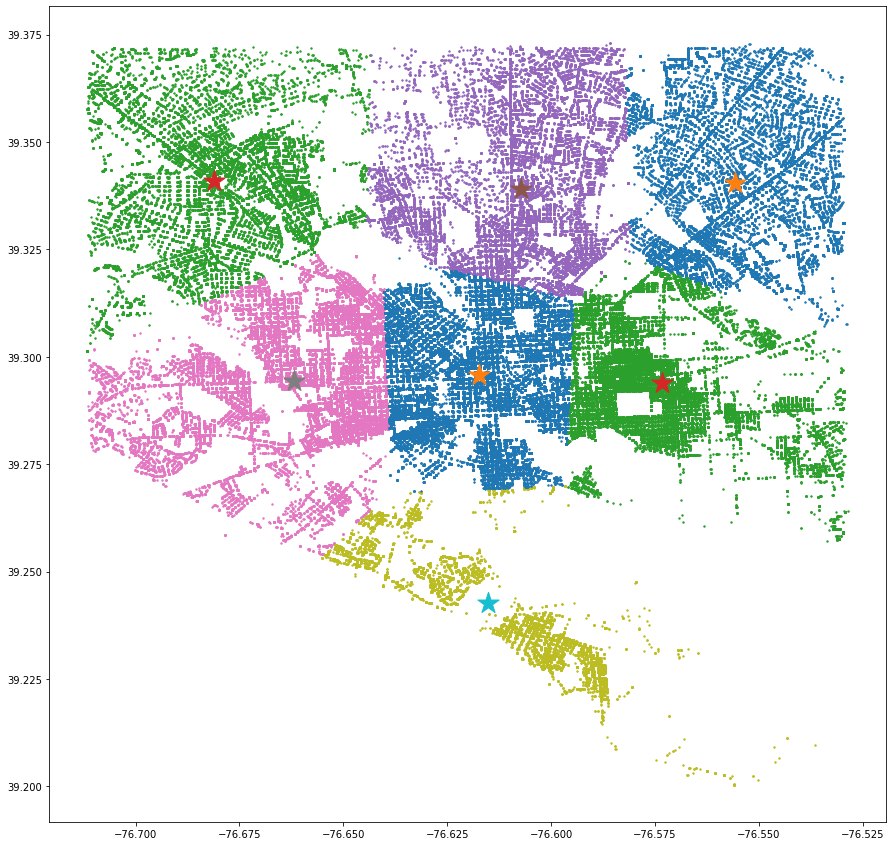

In [49]:
kmeans = Kmeans(7)
kmeans.fit(X, 40)

plot_clusters(kmeans, X, kmeans.which_clusters)